# Mini Project 2 - SVM for Classification

### Instructions on How to Run

1. **Open** the Jupyter notebook.
2. **Ensure** you have **NumPy**, **Matplotlib**, **scikit-learn**, and **mpl_toolkits** installed.
3. **Run** each cell in order from top to bottom.
4. The synthetic dataset is generated using scikit-learn’s `make_classification`.
5. Each **section** prints outputs or plots relevant to the project requirements.

# Introduction

In this project, we apply a Support Vector Machine (SVM) using mini-batch gradient descent to a synthetic dataset. The key objective is to implement a soft-margin SVM classifier that balances the trade-off between maximizing the margin and minimizing classification errors.

**Key Formulas:**

- **Regularization Term :**
  $$
  \frac{1}{2} \|w\|^2
  $$
  
- **Hinge Loss:**
  $$
 \max\Big(0,\, 1 - y_i \big(w^T x_i + b\big)\Big)
  $$

- **Total Loss Function:**
  $$
  J(w, b) = \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} \max\Big(0,\, 1 - y_i \big(w^T x_i + b\big)\Big)
  $$

- **Decision Function (for class prediction):**
  $$
  \hat{y} = \begin{cases}
  1 & \text{if } w^T x_i + b ≥ 0 \\
  -1 & \text{otherwise}
  \end{cases}
  $$

# Importing the Necessary Libraries and the Dataset

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification

In [2]:
X, y = make_classification(n_samples=500, n_features=3, n_informative=3,
                           n_redundant=0, n_clusters_per_class=1,
                           flip_y=0.1,  # adds a small amount of noise
                           class_sep=1.0,  # classes are separable but not too easily
                           random_state=40)

# Data Exploration

**Goal**: Examine the dataset.

In [3]:
X.shape

(500, 3)

The Dataset has 500 instances and for each instance, it has 3 attributes and one target value.

In [4]:
feature_names = [f"Feature_{i+1}" for i in range(X.shape[1])]

# Computing mean and standard deviation for each feature
mean_features = np.mean(X, axis = 0)
std_features = np.std(X, axis = 0)

print(f"{'Feature Name':<18} || {'Datatype':<10} || {'Mean':<14} || {'Standard Deviation'}")
print("-" * 73)

for i, feature in enumerate(feature_names):
    dtype_str = str(X[:, i].dtype)  # Convert dtype to string
    print(f"{feature:<18} || {dtype_str:<10} || {mean_features[i]:<14.3f} || {std_features[i]:.3f}")

Feature Name       || Datatype   || Mean           || Standard Deviation
-------------------------------------------------------------------------
Feature_1          || float64    || -0.003         || 1.702
Feature_2          || float64    || -0.047         || 1.395
Feature_3          || float64    || 0.953          || 0.784


Clearly, all the features consist of numeric (float) data.

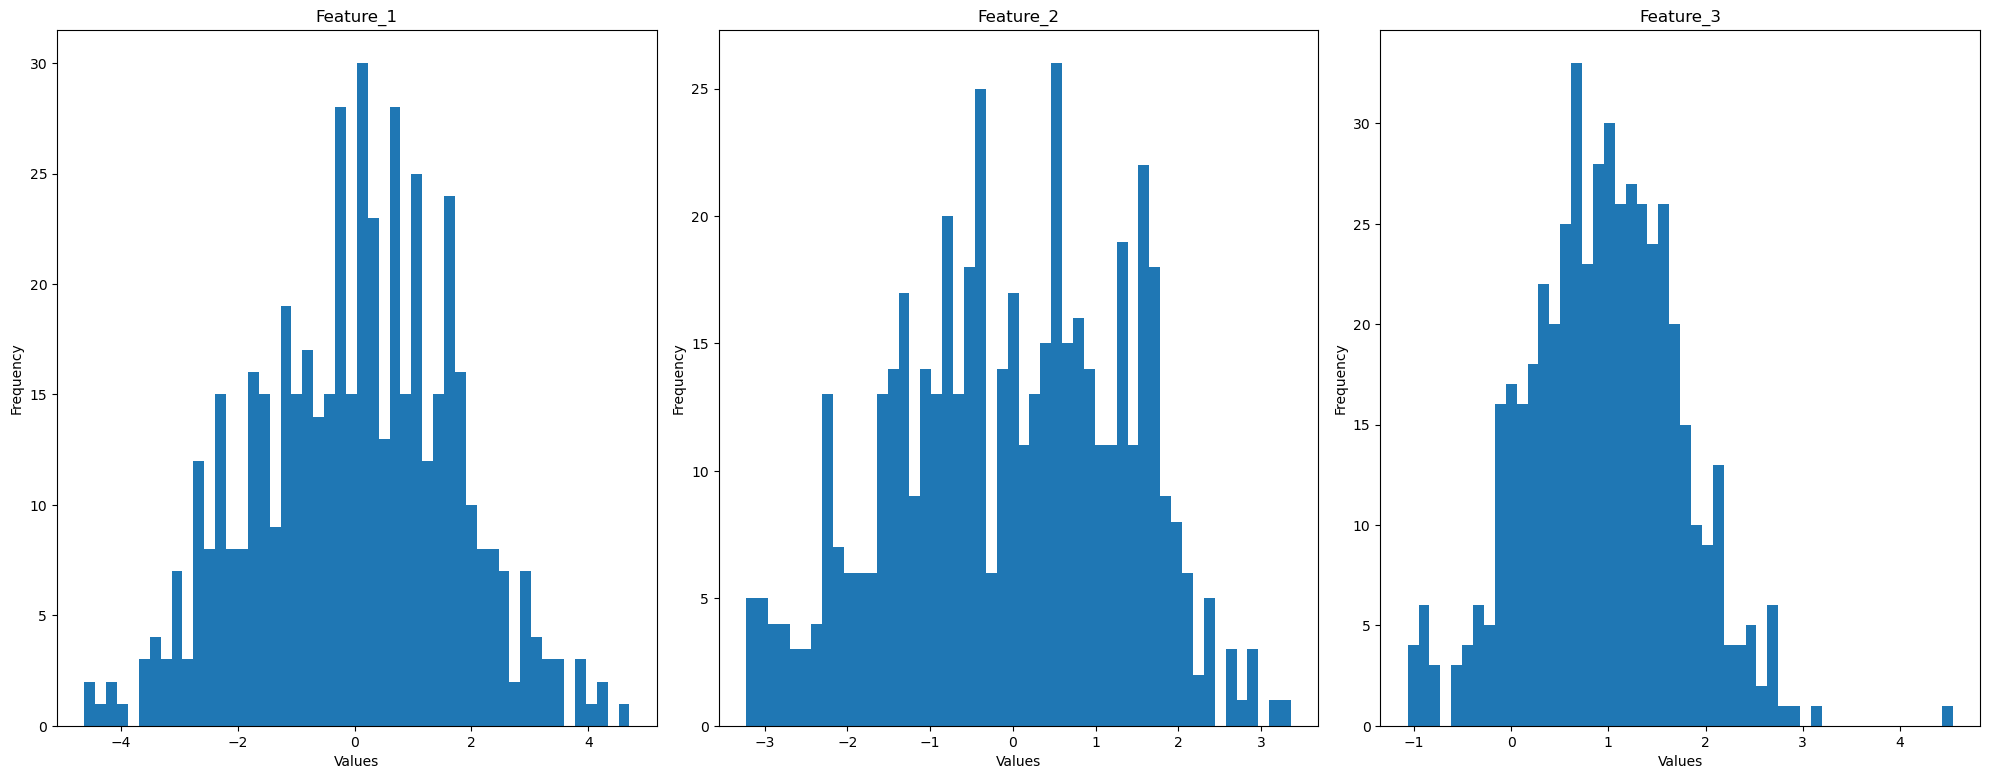

In [5]:
plt.figure(figsize = (20,15))
n = len(feature_names)

for i, feature in enumerate(feature_names):
    plt.subplot((n // 3) + 1, 3, i + 1)
    plt.hist(X[:, i], bins = 50)
    plt.title(feature)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Relabel the Y targets to +1/-1

To prepare our dataset for the SVM classifier, it's crucial that the target labels are correctly formatted to match the expected inputs of the SVM algorithm. The SVM classifier uses +1 and -1 to distinguish between the two classes. We adjust the target labels accordingly:

- Change labels of the class originally marked as `0` to `-1`.

In [6]:
y[y==0] = -1  # Relabel class '0' as '-1'

# Data Preprocessing

In [7]:
# Split the dataset into training and testing sets (80% train, 20% test).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# To ensure that every call to the random function will draw from the same sequence
np.random.seed(42)

n_train = X_train.shape[0]
n_test = X_test.shape[0]

# Normalize features
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)

# Avoid division by zero
X_std[X_std == 0] = 1

X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# Reshaping y_train and y_test
y_train = y_train.reshape(n_train, 1)
y_test = y_test.reshape(n_test, 1)

# Implementing Soft Margin SVM

### Define the following functions:

**Decision Function:**  
Computes the function `f(x) = Xw + b`.

**Hinge Loss:**  
For a single sample, computes `max(0, 1 - y * f(x))`.

**SVM Loss:**  
Computes the total loss over all samples by summing the hinge losses and adding the regularization term `(1/2) * ||w||^2` scaled by hyperparameter `C`.

**Gradient Calculation:**  
Computes the gradients of the loss with respect to `w` and `b` (summing over the samples that violate the margin) and includes the regularization derivative.


In [8]:
def decision_function(w,x, b):
    return (np.dot(x, w) + b)

In [9]:
def hinge_loss(x, y, w, b):
    return np.maximum(0, 1 - y * decision_function(w, x, b))

In [10]:
def svm_loss(X, y, w, b, C):
    n = X.shape[0]
    margins = hinge_loss(X, y, w, b)
    reg_loss = 0.5 * np.sum(w**2)
    total_loss = reg_loss + C * np.sum(margins)

    return total_loss
    

In [11]:
def gradient(X, y, C, w, b):
    n = X.shape[0]
    XY = np.zeros(w.shape)
    Y = 0
    w_grad = np.zeros_like(w)
    b_grad = 0

    for i in range(n):
        hinge = hinge_loss(X[i], y[i], w, b)

        if (hinge != 0):  # Only update gradient if hinge loss is non-zero
            XY += y[i]*X[i]
            Y += y[i] 
        
    w_grad = w - C*XY
    b_grad = -C*Y

    return w_grad, b_grad        
    

# Mini-Batch Gradient Descent

Here, we implement the training process:
- Shuffle the training data and create mini-batches.
- For each mini-batch:
    - **Compute the gradient of the loss** with respect to `w` and `b`.
    - **Update the parameters** using: 
        - `w = w - α * grad_w`
        - `b = b - α * grad_b`
- **Log the hinge loss periodically** (e.g., every 50 epochs).


In [12]:
def create_batch(X, y, batch_size):
    mini_batch_list = []
    n = X.shape[0]

    # Combine X and y for shuffling together
    data = np.column_stack((X,y))
    np.random.shuffle(data)
    no_of_batches= n // batch_size

    # Create batches of size 'batch_size'
    for i in range(no_of_batches):
        mini_batch = data[i*batch_size : (i+1)*batch_size]
        X_batch = mini_batch[:, :-1]
        y_batch = mini_batch[:, -1]
        mini_batch_list.append((X_batch, y_batch))

    # If there is a remainder, create a final batch
    if (n % batch_size != 0):
        mini_batch = data[no_of_batches * batch_size:]
        X_batch = mini_batch[:, :-1]
        y_batch = mini_batch[:, -1]
        mini_batch_list.append((X_batch, y_batch))

    return mini_batch_list

In [13]:
def mini_batch_gradient_descent(X_train, y_train, C, alpha, n_iterations, batch_size):
    hinge_losses = []
    n = X_train.shape[0]
    
    # Random Initialization
    w = np.random.randn(X_train.shape[1])
    b = np.random.randn()
    
    for i in range (n_iterations):
        mini_batch_list = create_batch(X_train, y_train, batch_size)

        # Update parameters for each mini-batch
        for X_batch, y_batch in mini_batch_list:
            w_grad, b_grad = gradient(X_batch, y_batch, C, w, b)
            w = w - alpha * w_grad
            b = b - alpha * b_grad
        
        if ((i + 1) % 50 == 0): # To print log loss after every 50 iterations
            current_loss = svm_loss(X_train, y_train, w, b, C)
            hinge_losses.append(current_loss) # Storing log losses to plot the "hinge loss vs iterations" graph
            print("Epoch ", i + 1, ": ", " Hinge Loss = ", current_loss)

    return w, b, hinge_losses

In [14]:
def predict(X, w, b):
    decision_vals = np.dot(X, w) + b

    predictions = np.where(decision_vals >= 0, 1, -1)

    return predictions

# Hyperparameter Tuning (Grid Search)

**Goal:** Use the test set as a validation set to find better hyperparameters.

### Outline:

1. **Define Ranges for the Hyperparameters:**
   - Specify the range of values for the hyperparameters.
   
---

2. **Iterate Over Each Combination:**
   - Use nested loops or a grid search approach to test every possible combination of the specified hyperparameter values.
   
---

3. **Train the Model with Each Configuration:**
   - For each combination of hyperparameters, train a new instance of the model using the training data.
   
---

4. **Evaluate Using Accuracy Score:**
   - Evaluate the model on the test set using accuracy score.

---

5. **Record and Report the Best Configuration:**
   - Keep track of the configuration that yields the best accuracy score and report these hyperparameters as the optimal configuration for the model.


In [15]:
# Define the hyperparameter grids
C_values = [0.5, 0.9]
alpha_values = [0.01, 0.05, 0.5]
n_iterations_values = [500, 750]
batch_size_values = [16, 32]

best_params = {}
best_accuracy = float('-inf')
n_train = X_train.shape[0]

# Grid search over hyperparameters
for C in C_values:
    for alpha in alpha_values:
        for n_iterations in n_iterations_values:
            for batch_size in batch_size_values:
                # Train the model using mini-batch gradient descent
                w, b, hinge_losses = mini_batch_gradient_descent(X_train, y_train, C, alpha, n_iterations, batch_size)
                
                # Make predictions on the "test" set using the parameters
                y_pred = predict(X_test, w, b)
                
                current_accuracy = accuracy_score(y_test, y_pred)
                
                print(f"C: {C}, alpha: {alpha}, Epoch: {n_iterations}, Batch Size: {batch_size}")
                print(f"Accuracy Score: {current_accuracy}\n")
                
                # Select the best hyperparameters: if F1 ties, use higher precision
                if current_accuracy > best_accuracy:
                    best_accuracy = current_accuracy
                    best_params = {'C': C, 'alpha': alpha, 'n_iterations': n_iterations, 'batch_size': batch_size}

Epoch  50 :   Hinge Loss =  92618.75642176124
Epoch  100 :   Hinge Loss =  92789.15569298218
Epoch  150 :   Hinge Loss =  92276.14997320209
Epoch  200 :   Hinge Loss =  92784.40062460206
Epoch  250 :   Hinge Loss =  92225.264898043
Epoch  300 :   Hinge Loss =  92723.9535969237
Epoch  350 :   Hinge Loss =  92382.90315636223
Epoch  400 :   Hinge Loss =  91967.97250501784
Epoch  450 :   Hinge Loss =  93218.06208181777
Epoch  500 :   Hinge Loss =  92528.54703064707
C: 0.5, alpha: 0.01, Epoch: 500, Batch Size: 16
Accuracy Score: 0.88

Epoch  50 :   Hinge Loss =  98218.63942359491
Epoch  100 :   Hinge Loss =  98179.54694015988
Epoch  150 :   Hinge Loss =  98327.33264396153
Epoch  200 :   Hinge Loss =  98549.97778166627
Epoch  250 :   Hinge Loss =  98028.09490046144
Epoch  300 :   Hinge Loss =  98398.4638500416
Epoch  350 :   Hinge Loss =  97986.45701490238
Epoch  400 :   Hinge Loss =  98158.25089359627
Epoch  450 :   Hinge Loss =  97999.88514216988
Epoch  500 :   Hinge Loss =  98178.30416530

In [16]:
print("Best Hyperparameters:", best_params)
print("Best Accuracy: ", best_accuracy)

Best Hyperparameters: {'C': 0.9, 'alpha': 0.01, 'n_iterations': 500, 'batch_size': 32}
Best Accuracy:  0.89


# Train the Model with Optimal Parameters

### Final Model Training & Evaluation
1. Using the optimal hyperparameters from the grid search, train the final SVM model.
2. Return the optimal weights 'w' and bias 'b'.

In [17]:
C_opt = best_params["C"] 
alpha_opt = best_params["alpha"] 
n_iterations_opt = best_params["n_iterations"] 
batch_size_opt = best_params["batch_size"] 

In [18]:
w_opt, b_opt, hinge_losses = mini_batch_gradient_descent(X_train, y_train, C_opt, alpha_opt, n_iterations_opt, batch_size_opt)

print("Optimal w: \n")
print(w_opt)

print("\nOptimal b: \n")
print(b_opt)

Epoch  50 :   Hinge Loss =  183013.54750469854
Epoch  100 :   Hinge Loss =  183867.40313309795
Epoch  150 :   Hinge Loss =  186803.30197137222
Epoch  200 :   Hinge Loss =  183182.21258201002
Epoch  250 :   Hinge Loss =  185705.81144546045
Epoch  300 :   Hinge Loss =  184733.44725806417
Epoch  350 :   Hinge Loss =  183309.1761836154
Epoch  400 :   Hinge Loss =  182807.0042746136
Epoch  450 :   Hinge Loss =  183465.93275082845
Epoch  500 :   Hinge Loss =  182948.12824740767
Optimal w: 

[-0.8625088  -1.03198339 -0.33205681]

Optimal b: 

0.13513955293298702


# Model Evaluation

Predict class labels on the test set and compute the accuracy score.

In [19]:
y_pred = predict(X_test, w_opt, b_opt)

In [20]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score: ", accuracy)

Accuracy Score:  0.89


# Visualizing the Training Data & Decision Boundary in 3D

## 2D Visualization

- **Create a meshgrid** over two of the features.
- **Compute the decision boundary** from the equation $$w_0x + w_1y + w_2z + b = 0$$
- **Plot the decision boundary** along with the training data.


In [21]:
x_vals = np.linspace(np.min(X_train[:, 0]), np.max(X_train[:, 0]), 50)
y_vals = np.linspace(np.min(X_train[:, 1]), np.max(X_train[:, 1]), 50)
labels = y_train.flatten()

X_mesh, Y_mesh = np.meshgrid(x_vals, y_vals)

Z_mesh = (-w_opt[0] * X_mesh - w_opt[1] * Y_mesh - b_opt) * 1. / w_opt[2]

In the following plot, red dots represent class +1, whereas blue dots represent class -1.

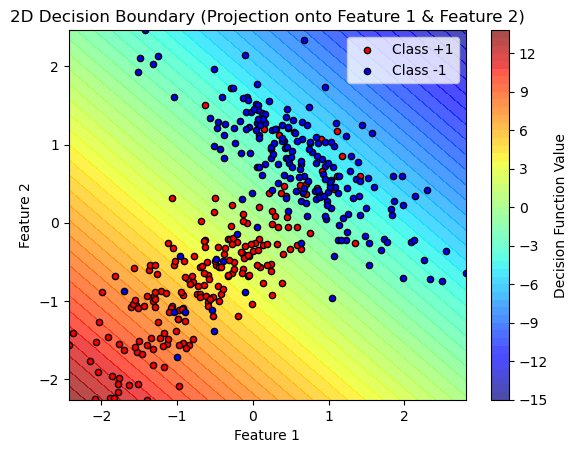

In [22]:
fig = plt.figure()

contour = plt.contourf(X_mesh, Y_mesh, Z_mesh, levels = 50, cmap = 'jet', alpha = 0.7)
plt.colorbar(contour, label='Decision Function Value')
plt.scatter(X_train[labels == 1, 0], X_train[labels == 1, 1], c = "red", edgecolors = 'k', s = 20, label = "Class +1")
plt.scatter(X_train[labels == -1, 0], X_train[labels == -1, 1], c = "blue", edgecolors = 'k', s = 20, label = "Class -1")

plt.title('2D Decision Boundary (Projection onto Feature 1 & Feature 2)')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

## 3D Visualization

- Plot the decision surface in 3D along with the training data points colored by their class labels.


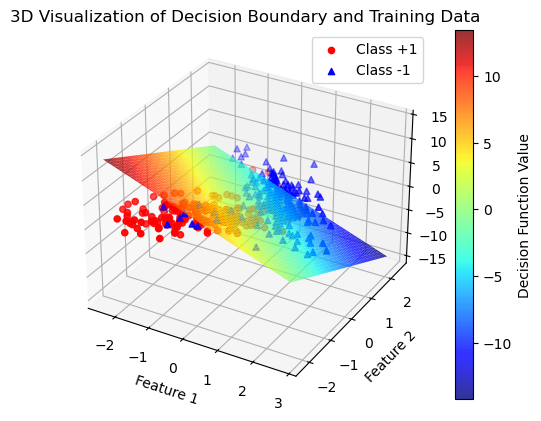

In [23]:
fig = plt.figure()
ax = plt.axes(projection = '3d')

surface = ax.plot_surface(X_mesh, Y_mesh, Z_mesh, cmap = "jet", alpha = 0.8)
ax.scatter(X_train[labels == 1, 0], X_train[labels == 1, 1], X_train[labels == 1, 2], c = 'r', marker = 'o', s = 20, label = 'Class +1')
ax.scatter(X_train[labels == -1, 0], X_train[labels == -1, 1], X_train[labels == -1, 2], c = 'b', marker = '^', s = 20, label = 'Class -1')

fig.colorbar(surface, label='Decision Function Value')
ax.set_title('3D Visualization of Decision Boundary and Training Data')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()
plt.show()

Now we modify the viewing angle to better observe how the decision boundary intersects the data clusters.

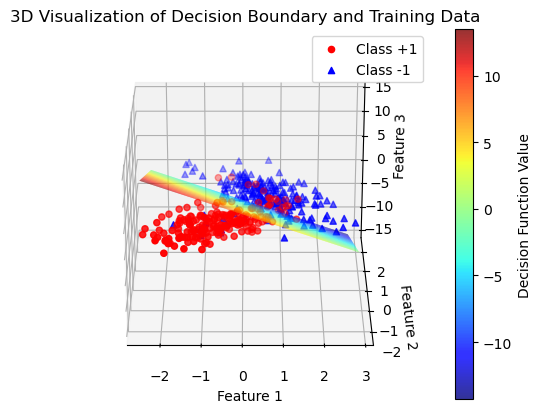

In [24]:
fig = plt.figure()
ax = plt.axes(projection = '3d')

surface = ax.plot_surface(X_mesh, Y_mesh, Z_mesh, cmap = "jet", alpha = 0.8)
ax.scatter(X_train[labels == 1, 0], X_train[labels == 1, 1], X_train[labels == 1, 2], c = 'r', marker = 'o', s = 20, label = 'Class +1')
ax.scatter(X_train[labels == -1, 0], X_train[labels == -1, 1], X_train[labels == -1, 2], c = 'b', marker = '^', s = 20, label = 'Class -1')

fig.colorbar(surface, label='Decision Function Value')
ax.set_title('3D Visualization of Decision Boundary and Training Data')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

ax.view_init(elev=25, azim=-90)
ax.legend()
plt.show()

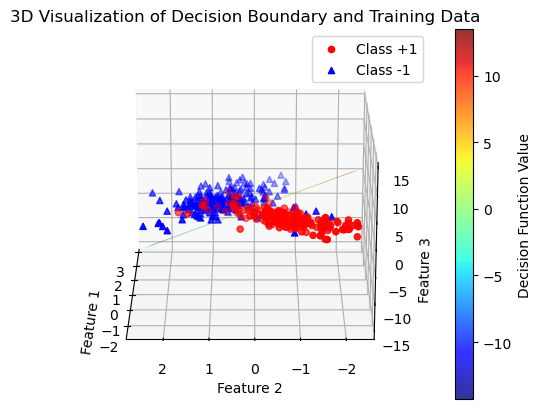

In [25]:
fig = plt.figure()
ax = plt.axes(projection = '3d')

surface = ax.plot_surface(X_mesh, Y_mesh, Z_mesh, cmap = "jet", alpha = 0.8)
ax.scatter(X_train[labels == 1, 0], X_train[labels == 1, 1], X_train[labels == 1, 2], c = 'r', marker = 'o', s = 20, label = 'Class +1')
ax.scatter(X_train[labels == -1, 0], X_train[labels == -1, 1], X_train[labels == -1, 2], c = 'b', marker = '^', s = 20, label = 'Class -1')

fig.colorbar(surface, label='Decision Function Value')
ax.set_title('3D Visualization of Decision Boundary and Training Data')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

ax.view_init(elev = 20, azim = -180)
ax.legend()
plt.show()

# Plotting Hinge Loss Over Iterations

Plot the hinge loss values over epochs to visualize the training progress.

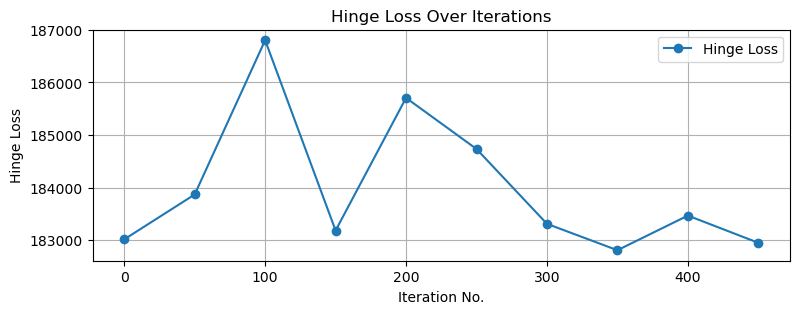

In [26]:
plt.figure(figsize = (9,3))
plt.title("Hinge Loss Over Iterations")
plt.xlabel("Iteration No.")
plt.ylabel("Hinge Loss")

# The x-axis corresponds to iterations (logged every 50 epochs)
plt.plot(range(0, len(hinge_losses)*50, 50), hinge_losses, marker = 'o', label = "Hinge Loss")
plt.grid(True)
plt.legend()
plt.show()